# 🚀 **SpaceX Falcon 9 first stage Landing Prediction**

## **1. Introduction**

The goal of this project is to **predict whether the Falcon 9 first stage will land successfully**.

Falcon 9 is a **reusable rocket** developed by the company SpaceX. It consists of two main parts (stages):

- **First stage** is responsible for the initial launch and pushing the rocket upwards into the sky
- Second stage activates after the first stage separates and is in charge of placing the payload into orbit

The key part is that the **first stage must land back on Earth** so it can be reused. 
SpaceX advertises a single Falcon 9 rocket launch at a cost of 62 million dollars, while other providers can charge upwards of 165 million dollars. A big part of the cost savings comes from being able to reuse the first stage.

If we can figure out what factors influence a successful landing, we can build a model to predict it — which helps with planning, saving money, and improving future missions.

As part of the IBM course, I completed labs on collecting data from the [SpaceX API]("https://api.spacexdata.com/v4/launches/past") and a [Wikipedia article]("https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches") on Falcon 9 launches. This notebook skips that part and uses the prepared `space-data.csv` file as the main data source.

## **2. Importing Libraries**

We begin by importing the necessary libraries that will help us analyze the data and build the prediction model:
- `pandas` for data manipulation and cleaning
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for exploratory data analysis (EDA) and visualization
- `scikit-learn` which provides implemented machine learning algorithms and tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

## **3. Loading and Exploring the Dataset**

We will import the dataset and convert it into a Dataframe object.

In [2]:
df = pd.read_csv("space-data.csv")

### **3.1 Preview of the dataset**
Let's take a quick look at the first few rows to understand the structure of the data.


In [3]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


In [4]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 90 rows and 17 columns.


#### **Column names**
Here are all the columns present in the dataset.

In [5]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude',
       'Latitude'],
      dtype='object')

#### **Feature Description (Data Dictionary)**

| Column Name      | Description |
|------------------|-------------|
| `FlightNumber`   | Number of the flight |
| `Date`           | Date of the launch |
| `BoosterVersion` | Falcon 9 booster model/version |
| `PayloadMass`    | Mass of the payload in kilograms |
| `Orbit`          | Destination orbit (e.g., LEO, GTO, etc.) |
| `LaunchSite`     | Location of the launch site |
| `Outcome`        | Landing outcome (success/failure) |
| `Flights`        | Number of previous flights using this booster |
| `GridFins`       | Whether grid fins were used (`True`/`False`) |
| `Reused`         | Whether the booster was reused (`True`/`False`) |
| `Legs`           | Whether the booster had landing legs |
| `LandingPad`     | Identifier of the landing pad used |
| `Block`          | Falcon 9 block number (sub-version) |
| `ReusedCount`    | How many times the booster has been reused |
| `Serial`         | Unique serial number of the booster |
| `Longitude`      | Longitude of the launch site |
| `Latitude`       | Latitude of the launch site |

#### **Data types**
We now check the data types of each column to see how the data is represented.

In [6]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

#### **Missing values**
Let's check if any columns contain missing values.

In [7]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

There are no missing values in the dataset that require attention. The `LandingPad` column will retain `None` values to represent when no landing pad was used.

### **3.2 Basic data exploration**
We start by answering a few simple questions about the dataset to get a better understanding of launch frequencies and outcomes.

#### **Launch activity per site**
The data includes several SpaceX launch facilities:
- Cape Canaveral Space Launch Complex 40 (CCAFS SLC-40)
- Vandenberg Air Force Base Space Launch Complex 4E (VAFB SLC-4E)
- Kennedy Space Center Launch Complex 39A (KSC LC-39A)

To get an overview of the dataset, we first check how many missions were conducted at each launch site.

In [8]:
df['LaunchSite'].value_counts()

LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

#### **Number and occurance of each orbit**
Each launch aims to a dedicated orbit. Let's determine how often each of them occurs in the dataset.

In [9]:
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

There are many types of orbits, but here I’ll briefly explain the most common ones found in the dataset:
- GTO (Geosynchronous Transfer Orbit): A high elliptical orbit used to move satellites into geostationary orbit.
- ISS (International Space Station): A habitable modular space station in low Earth orbit operated by multiple space agencies.
- VLEO (Very Low Earth Orbit): Orbits below 450 km, closer to Earth, good for detailed observation.
- PO (Polar Orbit): Orbit passing near Earth’s poles, allowing satellites to cover the entire planet.
- LEO (Low Earth Orbit): Orbit up to 2,000 km above Earth. Most satellites and the ISS orbit here.
- SSO (Sun-Synchronous Orbit): A near-polar orbit that passes over the same Earth spots at the same local solar time daily, ideal for consistent lighting conditions in imaging.

#### **Landing outcomes**

Each landing attempt is labeled by location and success:
- RTLS – landed on ground pad near the launch site
- ASDS – landed on drone ship in the ocean
- Ocean – soft landing in the ocean without a pad

Each can be marked as **True** (successful), **False** (failed), or **None** (no landing attempt).

Here is how often each of them appears in the dataset.

In [10]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

The `Outcome` column has full landing info, but for easier and cleaner analysis we need a new column with just binary values — success or failure.

We create a set of outcomes where the first stage did not land successfully.

In [11]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [12]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Based on the `Outcome` column, we make a new list: if the outcome was bad, we put 0, if it was good, we put 1.

In [13]:
landing_class = [0 if x in bad_outcomes else 1 for x in df['Outcome']]
df['Class'] = landing_class
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [14]:
df['Class'].value_counts()

Class
1    60
0    30
Name: count, dtype: int64

There have been 60 successful first stage landings and 30 unsuccessful ones.


#### **Converting the `Date` column**
The `Date` column contains full timestamps including day and month, which are not needed for our yearly trend analysis. We will convert it to contain only the launch year.

In [19]:
year=[]
for i in df["Date"]:
    year.append(i.split("-")[0])

df['Date'] = year

In [20]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,FlightBin
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0,"(0, 10]"
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0,"(0, 10]"
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0,"(0, 10]"
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0,"(0, 10]"
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0,"(0, 10]"


## **4. Exploratory Data Analysis**

It's time to dig deeper into the data and uncover hidden patterns using EDA.

#### **Landing success trend over time**
This line chart illustrates how Falcon 9's landing success rate has evolved over time.

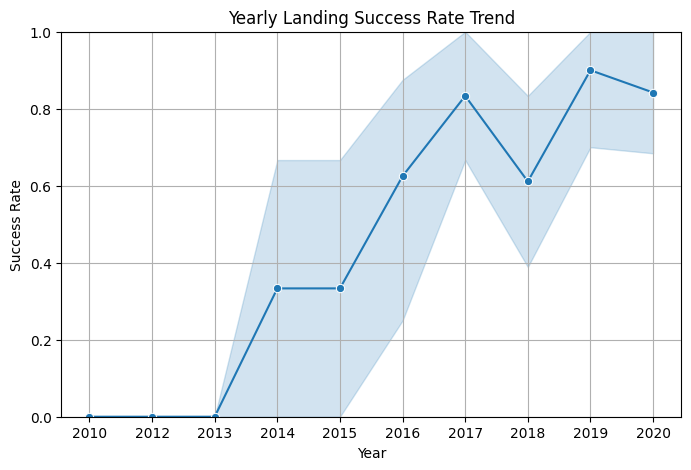

In [29]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x='Date', y='Class', marker='o')
plt.title("Yearly Landing Success Rate Trend")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

The chart shows a clear upward trend in the success rate over the years - beginning from 2013. 

#### **Flight number vs Payload mass**
Let's try to see how the `FlightNumber` (indicating the continuous launch attempts) and `PayloadMass` variables would affect the launch outcome.

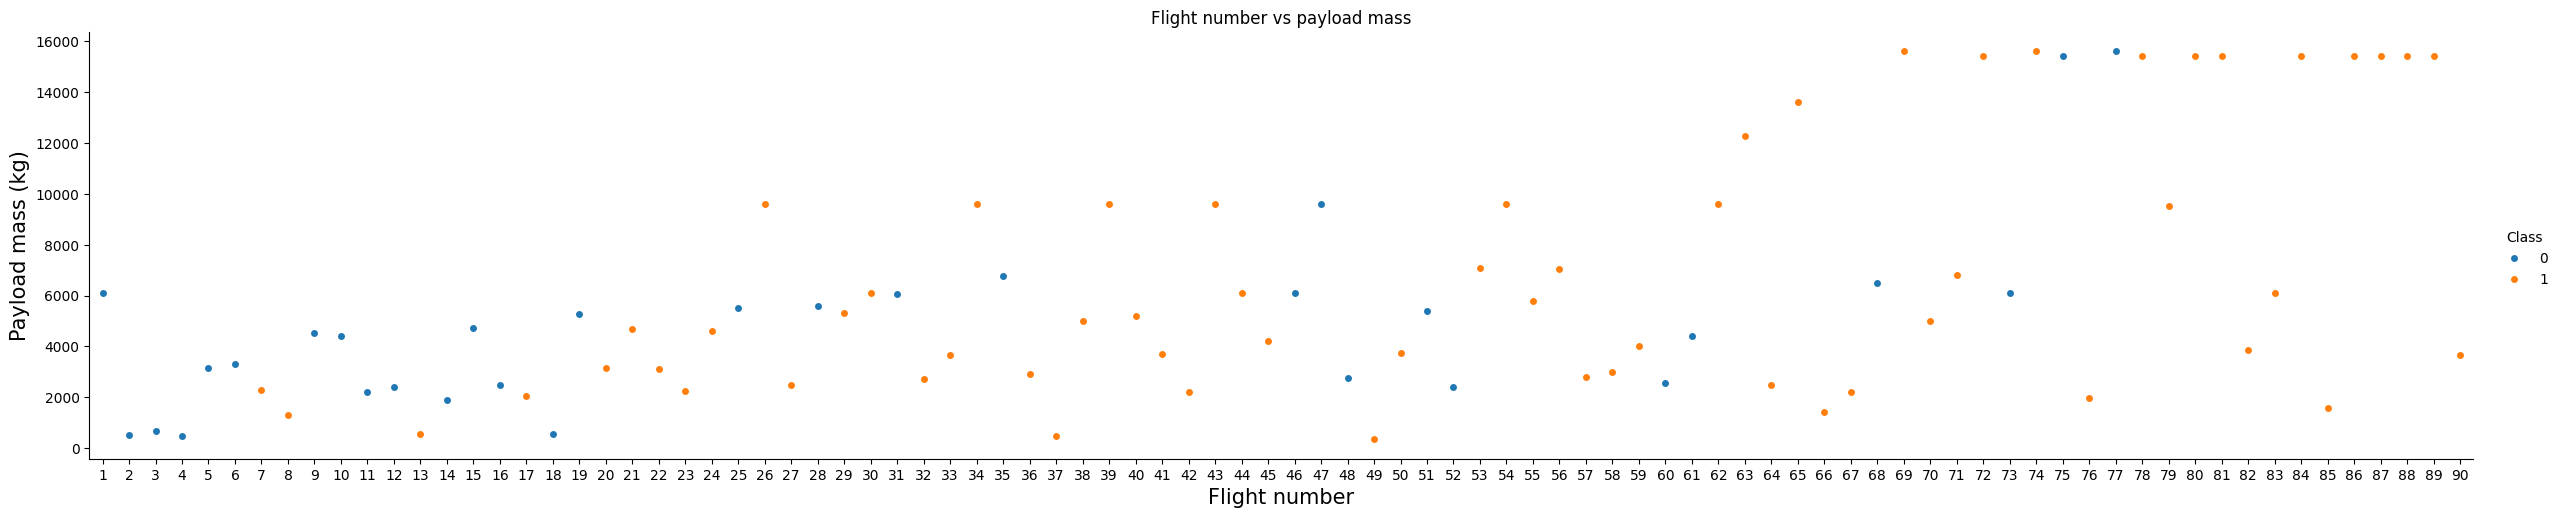

In [98]:
sns.catplot(x="FlightNumber", y="PayloadMass", hue="Class", data=df, aspect=5)
plt.title("Flight number vs payload mass")
plt.xlabel("Flight number",fontsize=15)
plt.ylabel("Payload mass (kg)",fontsize=15)
plt.show()

We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass also appears to be a factor; even with more massive payloads, the first stage often returns successfully. In 30 most recent missions the weight significantly increases.

#### **Launch site distribution**
What is the success rate of different launch sites? Let's plot a scatter plot of `FlightNumber` vs `LaunchSite`, as well as the average success rate for each site.

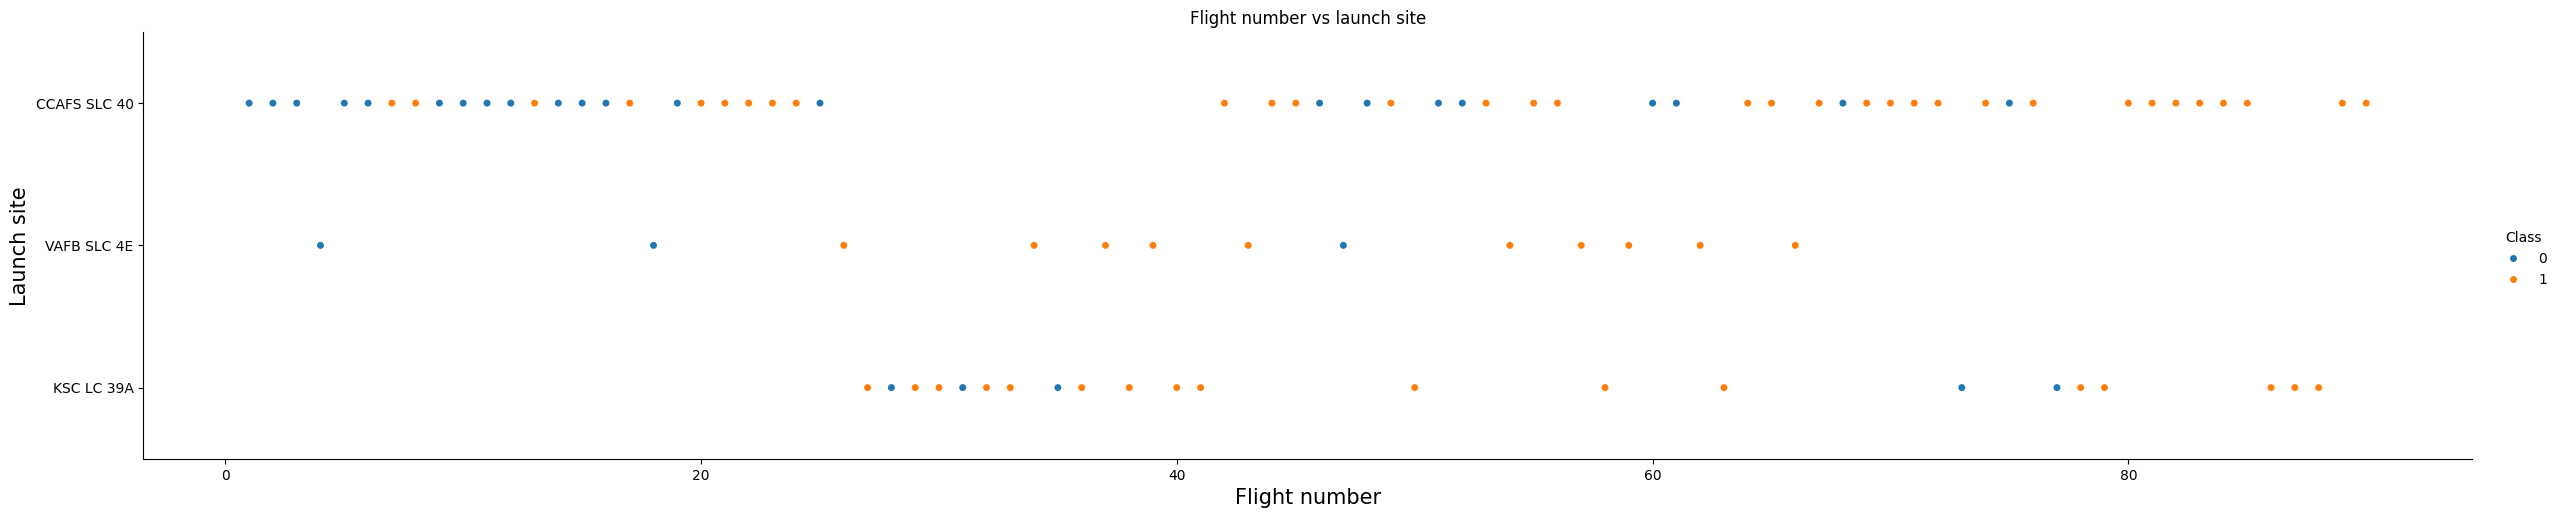

In [52]:
sns.catplot(x="FlightNumber", y="LaunchSite", hue="Class", data=df, aspect=5, jitter=False)
plt.title("Flight number vs launch site")
plt.xlabel("Flight number", fontsize=15)
plt.ylabel("Launch site", fontsize=15)
plt.show()

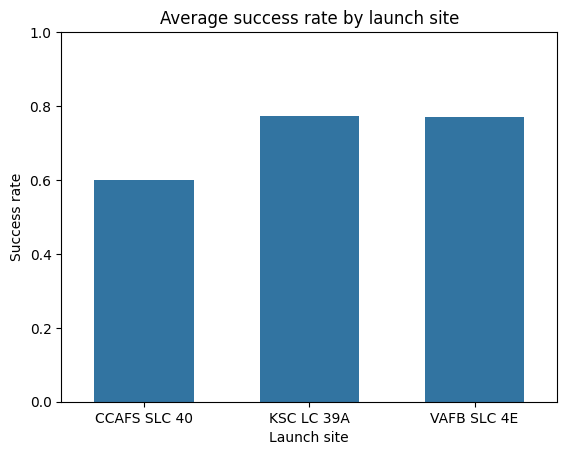

In [65]:
df_ls = df.groupby('LaunchSite')['Class'].mean().reset_index()

sns.barplot(x='LaunchSite', y='Class', data=df_ls, width=0.6)
plt.title("Average success rate by launch site")
plt.ylim(0, 1)
plt.xlabel("Launch site")
plt.ylabel("Success rate")
plt.show()

The most commonly used launch site is **CCAFS-SLC 40**. It concentrates most of the failures, particularly in the early stage of the Falcon 9 project.

#### **Orbit type distribution**
What is the success rate for different orbit types? Let's plot a scatter plot of `FlightNumber` vs `Orbit`, as well as the average success rate for each orbit.

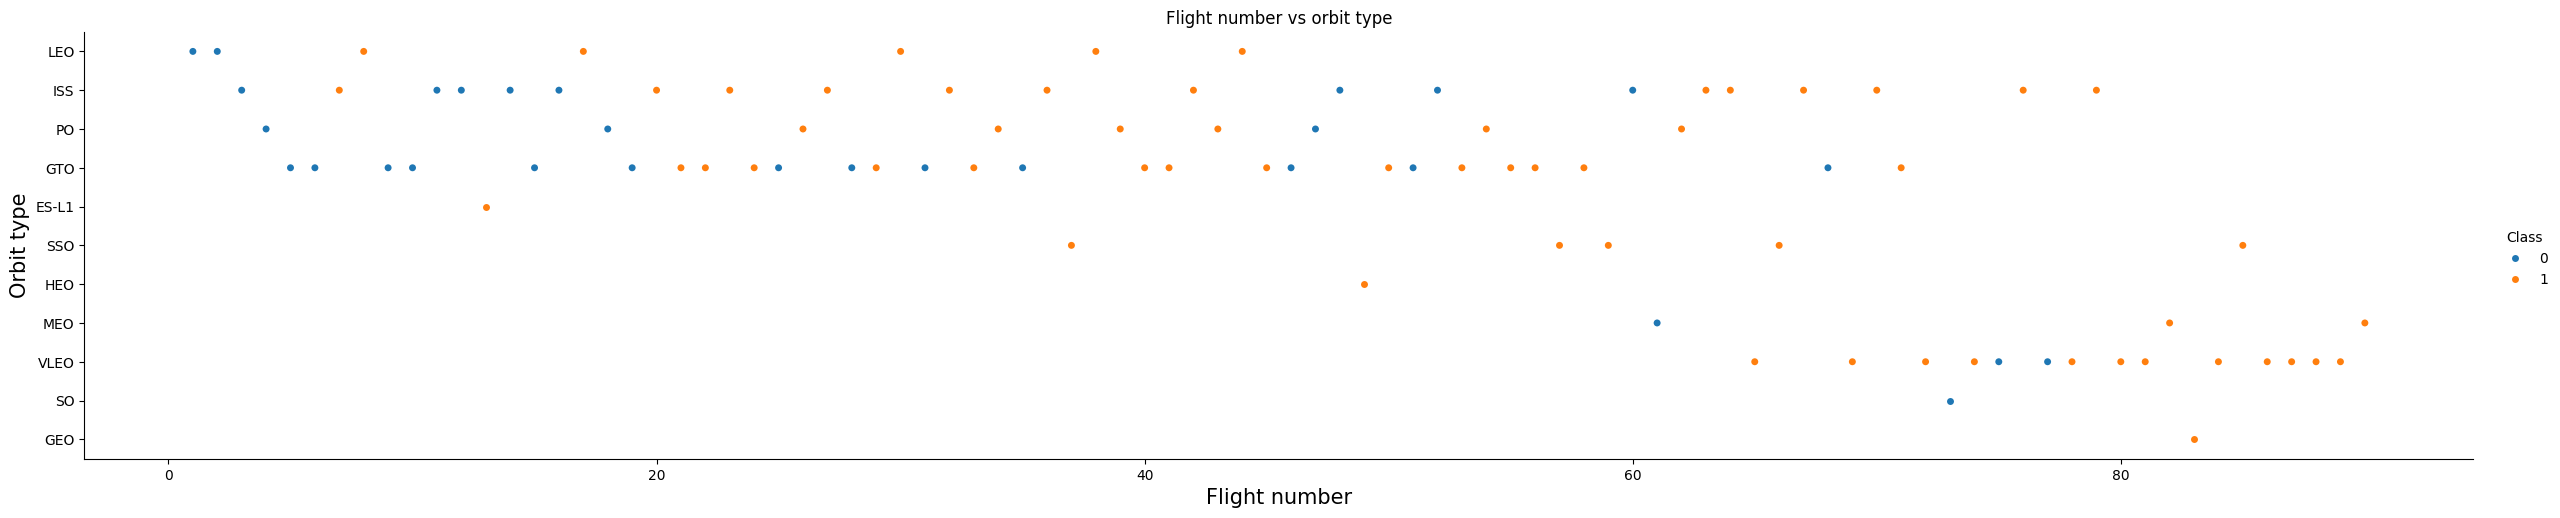

In [96]:
sns.catplot(x="FlightNumber", y="Orbit", hue="Class", data=df, aspect=5, jitter=False)
plt.title("Flight number vs orbit type")
plt.xlabel("Flight number", fontsize=15)
plt.ylabel("Orbit type", fontsize=15)
plt.show()

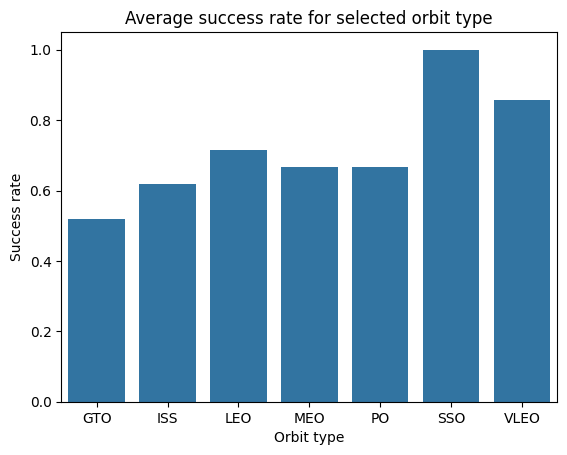

In [95]:
selected_orbits = ['LEO', 'ISS', 'PO', 'GTO', 'SSO', 'VLEO', 'MEO']
df_orb = df.groupby('Orbit')['Class'].mean().reset_index()
df_orb = df_orb[df_orb['Orbit'].isin(selected_orbits)]

sns.barplot(x='Orbit', y='Class', data=df_orb)
plt.title("Average success rate for selected orbit type")
plt.xlabel("Orbit type")
plt.ylabel("Success rate")
plt.show()

As stated in [3.2](####number-and-occurance-of-each-orbit), there are several distinct orbit types. However, some of them — specifically ES-L1, HEO, SO, and GEO — have only one recorded flight each. Due to their low occurrence, they are excluded from the second chart to keep the analysis focused and clear.

- Early missions targeted mainly orbits like LEO, ISS, PO and GTO. As the Falcon 9 project became more advanced, mission profiles got more diverse, aiming for VLEO, MEO and SSO as well.
- Orbits with the highest success rates like SSO, VLEO, LEO and PO are all located relatively close to Earth. This suggests that **lower orbits tend to be less risky**. In contrast, GTO (a higher orbit) shows the highest failure rate.
- As shown earlier, there is a noticeable **trend where higher flight numbers correspond to increased success rates**. This is especially noticeable for missions targeting LEO. The relationship between flight number and other orbits varies and isn't always that stable.

Do these factors influence how successful each launch site is? Let's create a heatmap showcasing the launch counts per `LaunchSite` and `Orbit`.

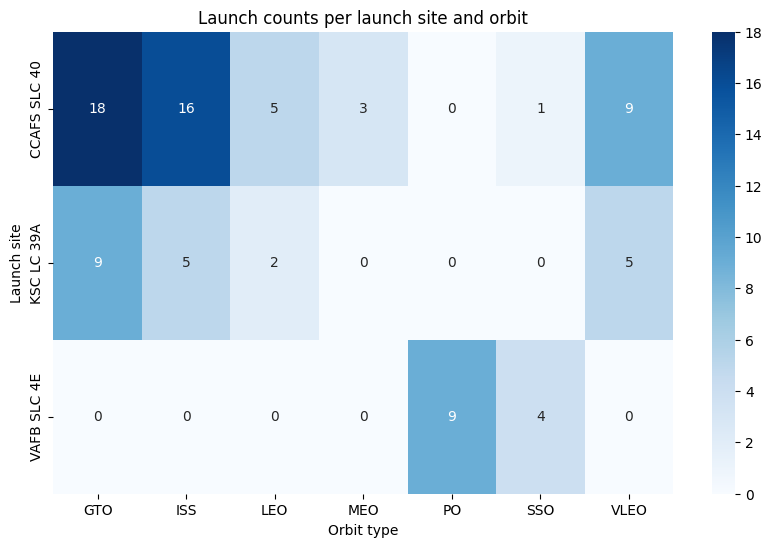

In [78]:
df_filtered = df[df['Orbit'].isin(selected_orbits)]
orbit_counts_full = df_filtered.groupby(['LaunchSite', 'Orbit']).size().reset_index(name='Count')
pivot_table = orbit_counts_full.pivot(index='LaunchSite', columns='Orbit', values='Count').fillna(0).astype(int)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues')
plt.title('Launch counts per launch site and orbit')
plt.ylabel('Launch site')
plt.xlabel('Orbit type')
plt.show()

We can see that the launch site with the most failures is the one targeting mainly the GTO orbit. It seems that one of the main factors behind the differences in launch sites is that **each of them focuses on specific orbits**.

#### **Payload mass vs launch site**
What is the relationship between the weight of the `PayloadMass` a rocket is carrying and the `LaunchSite` from which it started?

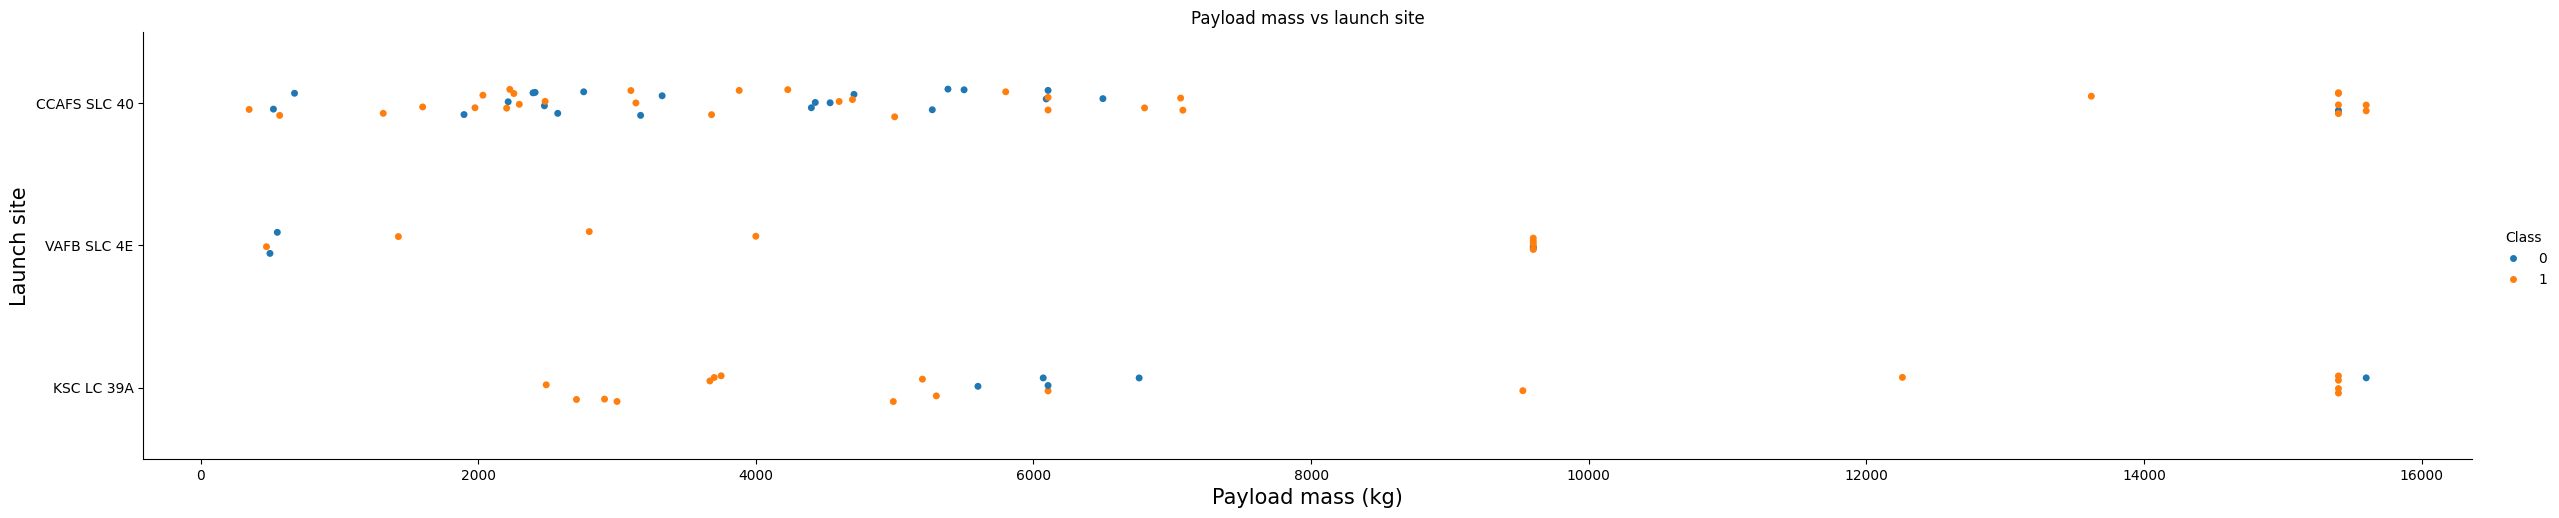

In [84]:
sns.catplot(x="PayloadMass", y="LaunchSite", hue="Class", data=df, aspect=5)
plt.title("Payload mass vs launch site")
plt.xlabel("Payload mass (kg)", fontsize=15)
plt.ylabel("Launch site", fontsize=15)
plt.show()

- Most of the launches from **CCAFS SLC 40 don't carry any heavy payload** (beyond around 7000 kg).
- VAFB-SLC 4E launch site has no rockets with payload exceeding 10000 kg.
- About 30 of the most recent missions carried the biggest weight with numerous successful outcomes. They form distinct clusters in both CCAPS SLC 40 and KSC LC 39A.
- Missions carrying **over 8000 kg of cargo are the ones with the highest success rate**. To gain some deeper insight, let's find out what is the correlation between success rate amd payload vs orbit type.

#### **Payload mass vs orbit type**
Do heavier cargos have a typical orbit that they go to?

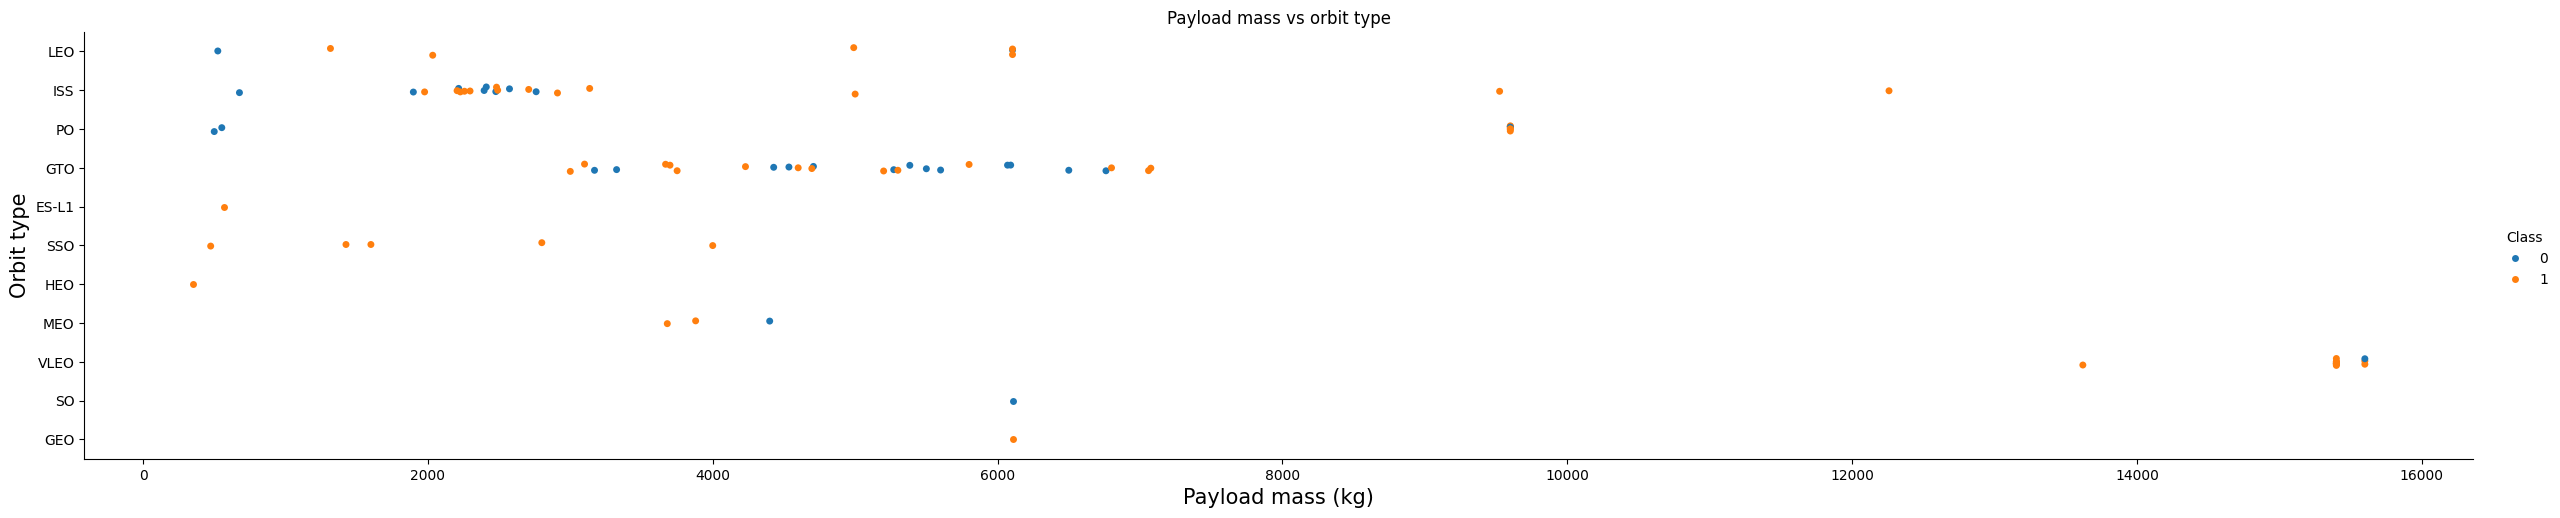

In [94]:
sns.catplot(x="PayloadMass", y="Orbit", hue="Class", data=df, aspect=5)
plt.title("Payload mass vs orbit type")
plt.xlabel("Payload mass (kg)", fontsize=15)
plt.ylabel("Orbit type", fontsize=15)
plt.show()

- It is clear that the **heaviest payloads are mainly launched to VLEO**. 
- Most launches to a specific orbit are enclosed within a specific payload mass range. For example, GTO: between 3000 and 7000 kg; ISS: between 2000 and 3500 kg; VLEO: around 15500 kg. There doesn't seem to be any correlation between that range and success rate.

## **5. Predictive Analysis (Classification)**

#### **Data preparation**

Now that we have obtained some preliminary insights about how each important variable would affect the success rate, we will **select the features that will be used in success prediction**. Before creating a model, we need to make sure our data is ready for the training process.

In [99]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


We will now convert all the categorical features (`Orbit`, `LaunchSite`, `LandingPad`, `Serial`) to numerical ones, using **one hot encoding**.

In [100]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], prefix=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


We obtained 80 columns which clearly define every bit of information about a flight. We will be able to feed the data to machine learning algorithms after we convert the remaining integer and boolean values to `float64`. We will assign it to the `df2` variable

In [101]:
df2 = features_one_hot.astype('float64')
df2.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
